This notebook is for making plots to be used in the IEEE PVSC presentation and manuscript. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from herbie import Herbie, FastHerbie
from toolbox import EasyMap, pc
import xarray as xr
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature

Load plant data:

In [3]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

Map of all the plants:

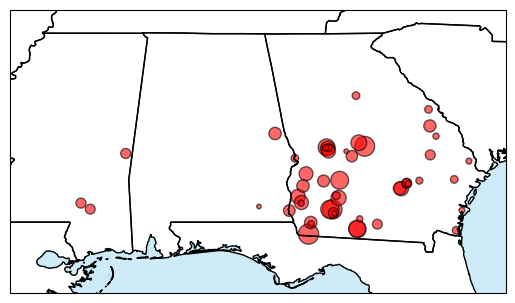

In [16]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)
ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-91, -80.5, 29.5, 35.5],
              crs=crs.PlateCarree()) ## Important


plt.scatter(x=plants_df.longitude, y=plants_df.latitude,
            color="red",
            edgecolors='black',
            s=plants_df.ac_capacity,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important
plt.savefig("images/fleet_map.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image
plt.show()

Make GEFS TCC plots based on [05_ensemble_variation_in_cloud_cover.ipynb](05_ensemble_variation_in_cloud_cover.ipynb). Start with a modified version of the helper function:

In [3]:
def sample_tcc_function(member, date, plants_df, plot='top'):
    ds = Herbie(
        date=date,
        model='gefs',
        product="atmos.5",
        member=member,
        fxx=36).xarray('TCDC',remove_grib=True)
    
    region_extent = [-92, -80, 30, 35]
    min_lon = (region_extent[0]+360) % 360
    max_lon = (region_extent[1]+360) % 360
    min_lat = region_extent[2]
    max_lat = region_extent[3]

    # slice to region extent
    ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

    # select values for each plant, assign ac capacity
    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]
    lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
    lons = xr.DataArray(lon_gefs, dims='plant_number')
    df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()
    df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

    # weighted average tcc
    weighted_avg_tcc = df.filter(regex='tcc').multiply(df['ac_capacity'].values,axis='index').sum()/df['ac_capacity'].sum()
    weighted_avg_tcc = weighted_avg_tcc.values[0]

    if plot=='top':
        ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[7, 6]).STATES().BORDERS().ax
        p = ax.pcolormesh(
            ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
        )

        # add plant markers with size corresponding to ac capacity
        plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity,
                    edgecolors='black', transform=pc)

        ax.set_title(
            f"{ds.model.upper()} - Ensemble Member {member} \
            \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
            \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
            loc="left",
        )
        # ax.set_title(ds['tcc'].GRIB_name, loc="right")
    elif plot=='bottom':
        ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[7, 6]).STATES().BORDERS().ax
        p = ax.pcolormesh(
            ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
        )

        # add a colorbar
        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            shrink=0.8,
            label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
        )

        # add plant markers with size corresponding to ac capacity
        plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity*2,
                    edgecolors='black', transform=pc)

        ax.set_title(
            f"{ds.model.upper()} - Ensemble Member {member}",
            loc="left",
        )
    else:
        ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[7, 6]).STATES().BORDERS().ax
        p = ax.pcolormesh(
            ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
        )

        # add plant markers with size corresponding to ac capacity
        plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity,
                    edgecolors='black', transform=pc)

        ax.set_title(
            f"{ds.model.upper()} - Ensemble Member {member}",
            loc="left",
        )
    
    plt.savefig(
        'images/tcc_map_' + pd.Timestamp(date).strftime('%Y%m%dT%H') + '_' + member + '.png',
        dpi=400,
        bbox_inches='tight',
        )
    plt.show()

    return df, weighted_avg_tcc

Then run it for days of interest:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


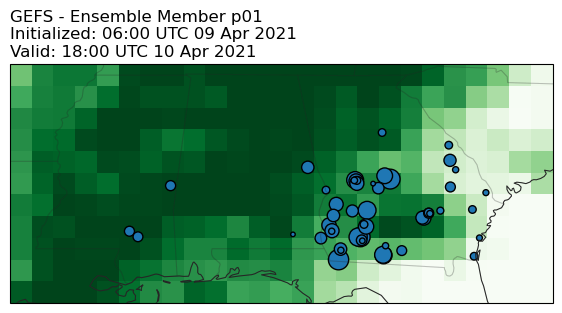

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


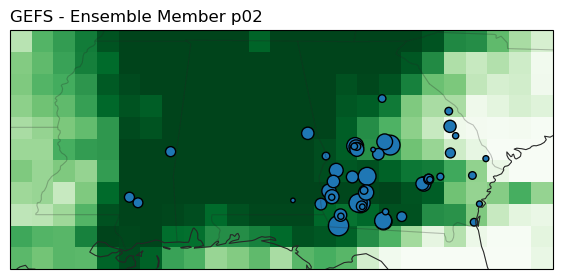

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


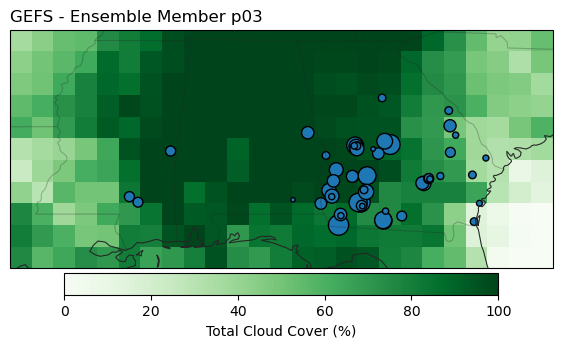

StDev of Weighted Avg TCC: 7.622321893738849
None
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


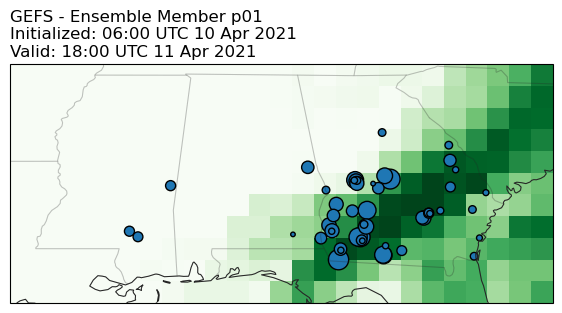

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


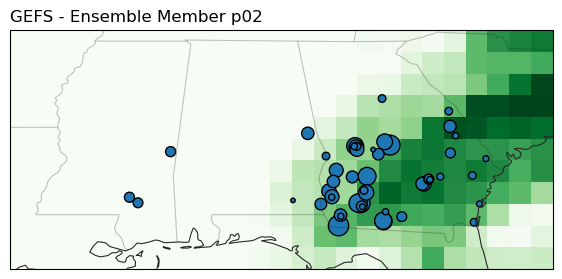

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


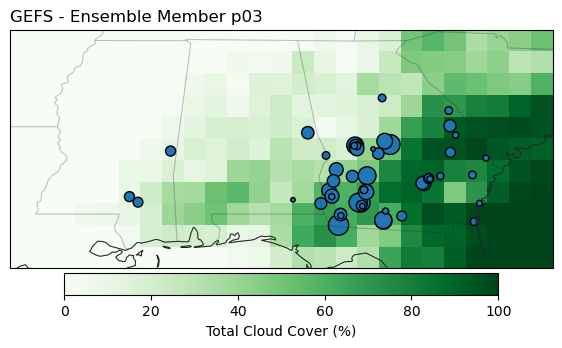

StDev of Weighted Avg TCC: 4.1243497898799
None
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


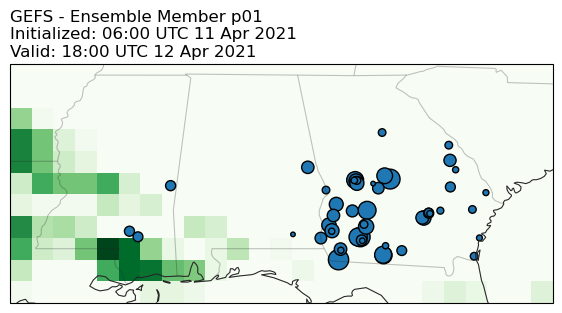

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


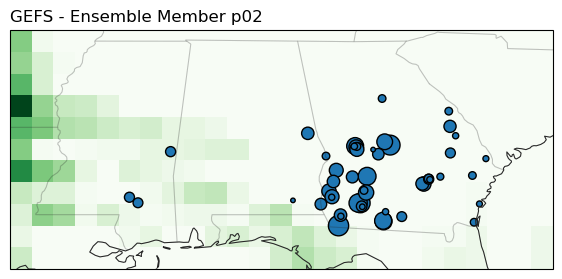

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


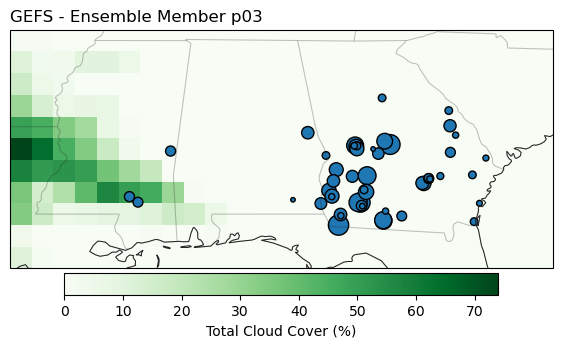

StDev of Weighted Avg TCC: 0.5872472301416806
None


In [4]:
date = '2021-04-09 06:00'
df_dict = {}
weighted_avg_tcc_dict = {}
df_dict[0], weighted_avg_tcc_dict[0] = sample_tcc_function(member='p01',date=date, plants_df=plants_df,plot='top')
df_dict[1], weighted_avg_tcc_dict[1] = sample_tcc_function(member='p02',date=date, plants_df=plants_df,plot='middle')
df_dict[2], weighted_avg_tcc_dict[2] = sample_tcc_function(member='p03',date=date, plants_df=plants_df,plot='bottom')
std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))

date = '2021-04-10 06:00'
df_dict = {}
weighted_avg_tcc_dict = {}
df_dict[0], weighted_avg_tcc_dict[0] = sample_tcc_function(member='p01',date=date, plants_df=plants_df,plot='top')
df_dict[1], weighted_avg_tcc_dict[1] = sample_tcc_function(member='p02',date=date, plants_df=plants_df,plot='middle')
df_dict[2], weighted_avg_tcc_dict[2] = sample_tcc_function(member='p03',date=date, plants_df=plants_df,plot='bottom')
std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))

date = '2021-04-11 06:00'
df_dict = {}
weighted_avg_tcc_dict = {}
df_dict[0], weighted_avg_tcc_dict[0] = sample_tcc_function(member='p01',date=date, plants_df=plants_df,plot='top')
df_dict[1], weighted_avg_tcc_dict[1] = sample_tcc_function(member='p02',date=date, plants_df=plants_df,plot='middle')
df_dict[2], weighted_avg_tcc_dict[2] = sample_tcc_function(member='p03',date=date, plants_df=plants_df,plot='bottom')
std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))

Now make HRRR max-min plot based on [06_indicators_of_forecast_error.ipynb](06_indicators_of_forecast_error.ipynb):

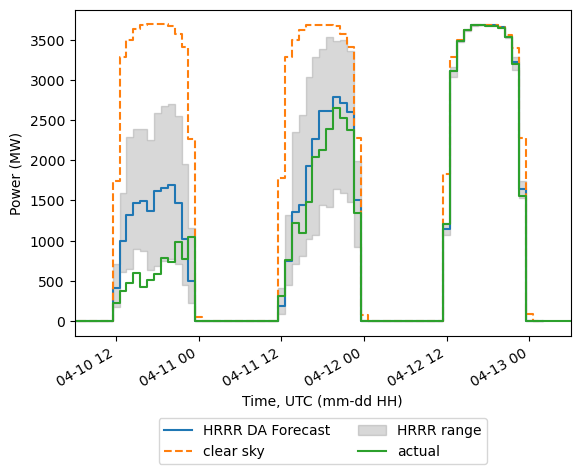

In [5]:
# load data
p_ac_hrrr_coarse_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_all.pkl')
p_ac_hrrr_coarse_max_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_max_all.pkl')
p_ac_hrrr_coarse_min_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_min_all.pkl')
max_min_norm = pd.read_pickle('example_data/max_min_norm_20210408.pkl')
weighted_avg_tcc = pd.read_pickle('example_data/weighted_avg_tcc_20210408.pkl')
power_ac_cs_all = pd.read_pickle('example_data/power_ac_cs_all.pkl')
p_ac_hrrr_actuals_all = pd.read_pickle('example_data/p_ac_hrrr_actuals_all.pkl')

# plot
mask = (power_ac_cs_all.index >= p_ac_hrrr_coarse_all.index[0]) & (power_ac_cs_all.index <= p_ac_hrrr_coarse_all.index[-1])
plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR DA Forecast')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky', linestyle='--')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='actual')
plt.ylabel('Power (MW)')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23),ncol=2)
plt.xlim([pd.Timestamp('2021-04-10 06:00'), pd.Timestamp('2021-04-13 06:00')])
plt.savefig('images/hrrr_max_min_cs.png', dpi=400, bbox_inches='tight')
plt.show()

And combining both indicators using all 30 GEFS members for TCC (also based on [06_indicators_of_forecast_error.ipynb](06_indicators_of_forecast_error.ipynb)):

C:\Users\willh\AppData\Local\Temp\ipykernel_106312\4235052865.py:37: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.gcf().autofmt_xdate()


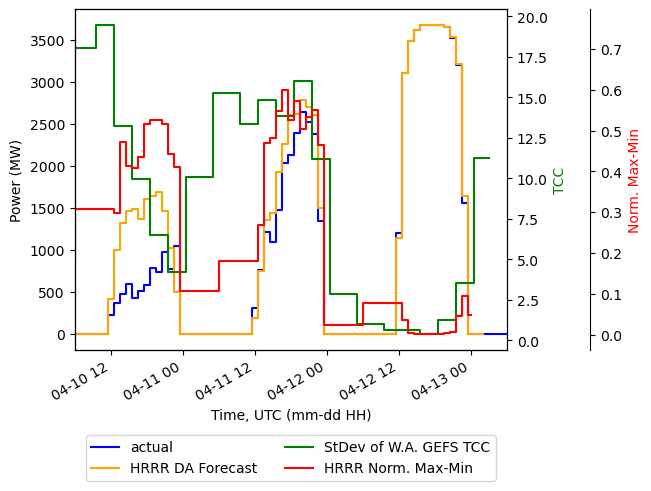

In [6]:
# Based on https://stackoverflow.com/a/45925049
# fig, ax1 = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches
fig, ax1 = plt.subplots(layout='constrained')
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
ax1.set_xlabel('Time, UTC (mm-dd HH)')
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("TCC")
ax3.set_ylabel("Norm. Max-Min")

p1 = ax1.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='actual',
         color='blue',
         )

p2 = ax1.plot(p_ac_hrrr_coarse_all.index,
              p_ac_hrrr_coarse_all.power_ac,
              drawstyle='steps-mid',
              label='HRRR DA Forecast',
              color='orange',
              )

p3 = ax2.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label='StDev of W.A. GEFS TCC', color='green')

p4 = ax3.plot(max_min_norm.index, max_min_norm.max_min_norm, drawstyle='steps-mid',
         label='HRRR Norm. Max-Min', color='red')

# right, left, top, bottom
ax3.spines['right'].set_position(('outward', 60))

ax2.yaxis.label.set_color(p3[0].get_color())
ax3.yaxis.label.set_color(p4[0].get_color())
plt.gcf().autofmt_xdate()
plt.xlim([pd.Timestamp('2021-04-10 06:00'), pd.Timestamp('2021-04-13 06:00')])
plt.legend(handles=p1+p2+p3+p4, loc='upper center', bbox_to_anchor=(0.5, -0.23),ncol=2)
plt.savefig('images/indicators_timeseries.png', dpi=400, bbox_inches='tight')
plt.show()

Scatter plot:

In [7]:
p_ac_hrrr_coarse_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_all'}, inplace=True)
p_ac_hrrr_coarse_max_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_max_all'}, inplace=True)
p_ac_hrrr_coarse_min_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_min_all'}, inplace=True)
power_ac_cs_all.rename(columns={'power_ac': 'power_ac_cs_all'}, inplace=True)
p_ac_hrrr_actuals_all.rename(columns={'power_ac': 'p_ac_hrrr_actuals_all'}, inplace=True)

# localize (assign timezone of UTC)
weighted_avg_tcc = weighted_avg_tcc.copy().tz_localize('UTC')

# list of dataframes to combiner first
dfs = [
    p_ac_hrrr_coarse_all,
    p_ac_hrrr_coarse_max_all,
    p_ac_hrrr_coarse_min_all,
    power_ac_cs_all,
    p_ac_hrrr_actuals_all,
    weighted_avg_tcc.tcc_std,
    ]

# combine all dataframes and drop na rows
df = pd.concat(dfs, axis=1).dropna()

# add max_min_norm
df = df.merge(max_min_norm, how='outer', left_index=True, right_index=True)

approx_nameplate = power_ac_cs_all.power_ac_cs_all.max() # use power_ac_cs_all.max() as proxy for nameplate rating
df['abs_err'] = (df.p_ac_hrrr_coarse_all - df.p_ac_hrrr_actuals_all).abs()
df['norm_abs_err'] = df.abs_err/approx_nameplate
df['cs_norm_abs_err'] = df.abs_err/df.power_ac_cs_all

df[df.power_ac_cs_all < approx_nameplate*0.01] = np.nan

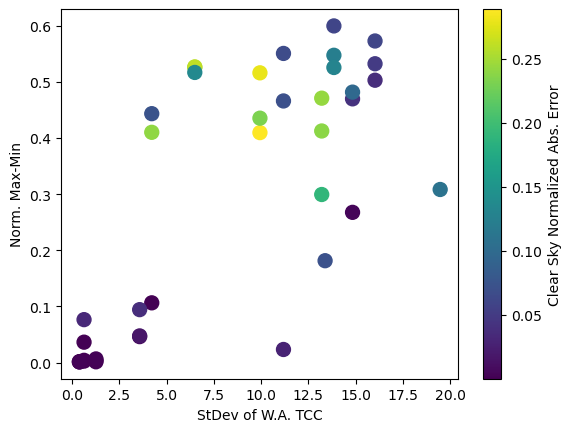

In [8]:
mask = (df.index >= '2021-04-10 06:00') & (df.index <= '2021-04-13 06:00')
plt.scatter(df.tcc_std[mask],
            df.max_min_norm[mask],
            c=df.cs_norm_abs_err[mask],
            s=100)
plt.colorbar(label='Clear Sky Normalized Abs. Error')
plt.xlabel('StDev of W.A. TCC')
plt.ylabel('Norm. Max-Min')
plt.savefig('images/indicators_scatter.png', dpi=400, bbox_inches='tight')
plt.show()

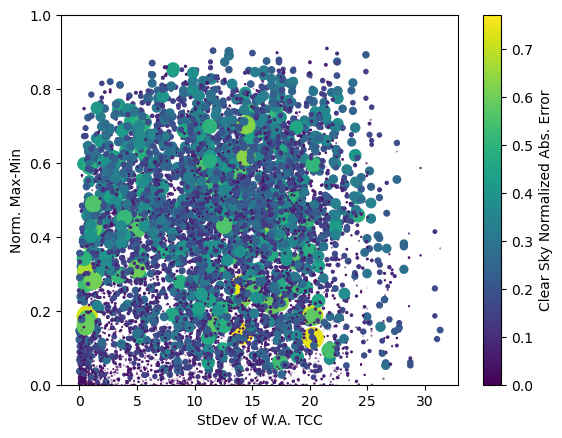

In [9]:
df2 = pd.read_pickle('data_files/full_2021_2023_dataset.pkl')
mask = (df2.index >= '2021-01-01') & (df2.index <= '2023-01-01')
plt.scatter(df2.tcc_std[mask],
            df2.max_min_norm[mask],
            s=(df2.csi_norm_abs_err[mask]*20)**2,
            c=df2.csi_norm_abs_err[mask])
plt.colorbar(label='Clear Sky Normalized Abs. Error')
plt.xlabel('StDev of W.A. TCC')
plt.ylabel('Norm. Max-Min')
plt.ylim([0,1])
plt.savefig('images/indicators_scatter_2yrs.png', dpi=400, bbox_inches='tight')
plt.show()

HRRR map figure:

In [268]:
ds = Herbie(date='2021-04-08 06:00', model='HRRR', product="sfc", fxx=36).xarray('DSWRF',remove_grib=True)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Apr-08 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


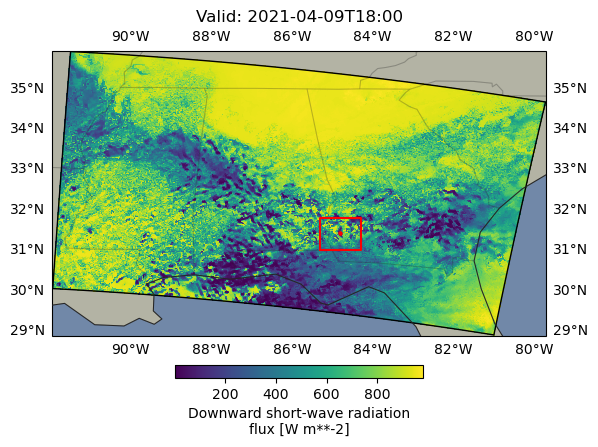

In [269]:
## crop to southeast
xmin, xmax = 1080, 1440
ymin, ymax = 220, 440
ds_cropped = ds.sel(x=slice(xmin, xmax), y=slice(ymin, ymax))

ax = EasyMap().STATES().OCEAN().LAND().DOMAIN(ds_cropped).ax
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax,
    transform=pc,
    cbar_kwargs={"shrink": 0.5, "orientation": "horizontal", "pad": 0.08},
)
ax.set_title('Valid: 2021-04-09T18:00')

## Target point of interest
lat, lon = 31.42, -84.82
# lat, lon = 30.9, -84.6 # Bainbridge, GA

## Zoom range of interest around target point
lonmin, lonmax = -85.3, -84.3
latmin, latmax = 31, 31.8
plt.scatter(lon,lat,s=5,c='r',)
coord = [[lonmin,latmin], [lonmin,latmax], [lonmax,latmax], [lonmax,latmin],[lonmin,latmin]]
xs, ys = zip(*coord) 
plt.plot(xs,ys,color='r') 

# grid lines/labels
ax.gridlines(draw_labels=True, linewidth=0)
plt.show()

In [328]:
## coarsen and calculate corner coordinates around our point for the coarsened grid
# coarsen
window_size = 10
ds_coarse = ds_cropped.coarsen(x=window_size, y=window_size, boundary='trim').mean() 

lats = {}
lons = {}
# HRRR res is 3 km, or about 0.3 deg lat/lon
# middle
dsp = ds_coarse.herbie.nearest_points(points=[(lon,lat)]) # target location
lats[0] = dsp.latitude.values.item()
lons[0] = dsp.longitude.values.item()-360

# NE
dsp = ds_coarse.herbie.nearest_points(points=[(lon+.3,lat+.3)]) # target location
lats[1] = dsp.latitude.values.item()
lons[1] = dsp.longitude.values.item()-360

# SE
dsp = ds_coarse.herbie.nearest_points(points=[(lon+.3,lat-.3)]) # target location
lats[2] = dsp.latitude.values.item()
lons[2] = dsp.longitude.values.item()-360

# SW
dsp = ds_coarse.herbie.nearest_points(points=[(lon-.3,lat-.3)]) # target location
lats[3] = dsp.latitude.values.item()
lons[3] = dsp.longitude.values.item()-360

# NW
dsp = ds_coarse.herbie.nearest_points(points=[(lon-.3,lat+.3)]) # target location
lats[4] = dsp.latitude.values.item()
lons[4] = dsp.longitude.values.item()-360

# calculate corner coordinates
c0 = [lons[0]-(lons[0]-lons[1])/2,lats[0]-(lats[0]-lats[1])/2]
c1 = [lons[0]-(lons[0]-lons[2])/2,lats[0]-(lats[0]-lats[2])/2]
c2 = [lons[0]-(lons[0]-lons[3])/2,lats[0]-(lats[0]-lats[3])/2]
c3 = [lons[0]-(lons[0]-lons[4])/2,lats[0]-(lats[0]-lats[4])/2]
coord = [c0, c1, c2, c3, c0]
xs_coarse, ys_coarse = zip(*coord) 

c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\pyproj\transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\accessors.py:258: UserWarning: Mo

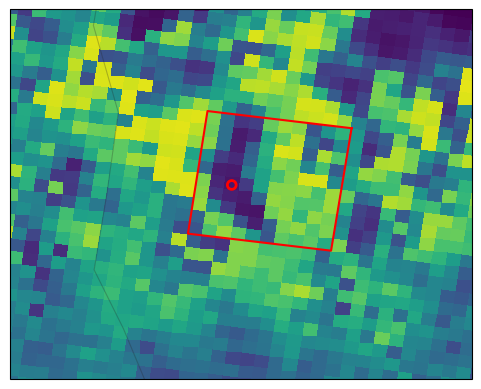

In [329]:
## Make a plot
ax = EasyMap().STATES().OCEAN().LAND().DOMAIN(ds_cropped).ax
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax,
    transform=pc,
    add_colorbar=False,
)

plt.scatter(lon,lat,s=40,c='none', edgecolor='r',marker='o',linewidths=2)
ax.set_title('')
ax.set_xlim(left=lonmin, right=lonmax)
ax.set_ylim(bottom=latmin, top=latmax)

plt.plot(xs_coarse, ys_coarse,color='r') 

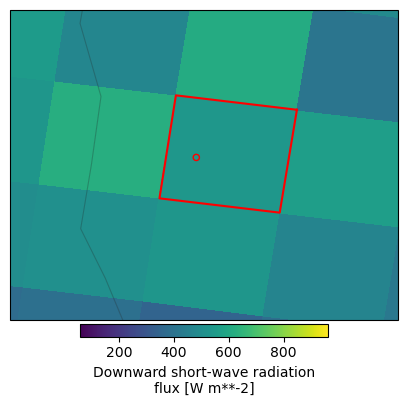

In [331]:
## make sure it looks right
ax = EasyMap().STATES().OCEAN().LAND().DOMAIN(ds_coarse).ax
ds_coarse.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax,
    transform=pc,
    cbar_kwargs={"shrink": 0.5, "orientation": "horizontal", "pad": 0.01},
    # add_colorbar=False
)
# plt.scatter(lon,lat,s=20,c='r')
plt.scatter(lon,lat,s=20,c='none', edgecolor='r',marker='o')
ax.set_title('')
ax.set_xlim(left=lonmin, right=lonmax)
ax.set_ylim(bottom=latmin, top=latmax)

plt.plot(xs_coarse, ys_coarse,color='r') 

Now, an inset:

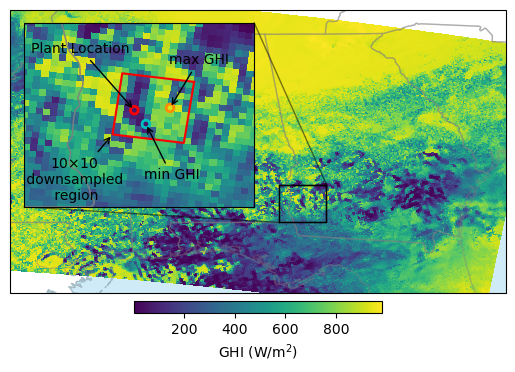

In [472]:
# based on https://matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html#sphx-glr-gallery-subplots-axes-and-figures-zoom-inset-axes-py

## Create first map
#------------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_extent([-91, -80.5, 29.5, 35.5],
              crs=crs.PlateCarree()) ## Important
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax,
    transform=pc,
    cbar_kwargs={"shrink": 0.5,
                 "orientation": "horizontal",
                 "pad": 0.02,
                 'label':'GHI (W/$\mathregular{m^2}$)'},
)

# ax.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)
ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES, edgecolor='gray', alpha=0.4)
# ax.set_title('Valid: 2021-04-09T18:00')
ax.set_title('')

# Target point of interest
lat, lon = 31.42, -84.82

# Zoom range of interest around target point
lonmin, lonmax = -85.3, -84.3
latmin, latmax = 31, 31.8
# ax.scatter(lon,lat,s=5,c='r',)
coord = [[lonmin,latmin], [lonmin,latmax], [lonmax,latmax], [lonmax,latmin],[lonmin,latmin]]
xs, ys = zip(*coord) 
ax.plot(xs,ys,color='k', linewidth=1) 

# uncomment to add lat/lon labels
# ax.gridlines(draw_labels=True, linewidth=0)
#------------------------

## Create second map
#------------------------
x_pos = 0.26
y_pos = 0.63
size = 0.65                 
ax2 = ax.inset_axes(
                    [x_pos - size / 2, y_pos - size / 2, size, size],
                    projection=crs.PlateCarree(),
                    xlim=(lonmin, lonmax),
                    ylim=(latmin, latmax))
ax2.add_feature(cfeature.STATES, edgecolor='gray', alpha=0.7)
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax2,
    transform=pc,
    add_colorbar=False,
)
ax2.set_title('')

## detail to inset
ax2.scatter(lon,lat,s=30,c='none', edgecolor='r',marker='o',linewidths=2)
ax2.plot(xs_coarse, ys_coarse,color='r') 
ax.indicate_inset_zoom(ax2, edgecolor="black")

## manually highlight max and min points
# max
ax2.scatter(-84.665,31.43,s=30,c='none', edgecolor='darkorange',marker='o',linewidths=2)
# min
ax2.scatter(-84.77,31.36,s=30,c='none', edgecolor='c',marker='o',linewidths=2)

ax2.annotate('Plant Location',
             xy=(lon,lat),
             xytext=(lon-.45,lat+.25),
             color='black',
            #  weight='bold',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

ax2.annotate(r'10$\times$10' +'\n downsampled \n region',
             xy=(xs_coarse[2],ys_coarse[2]),
             xytext=(lon-.26,lat-.39),
             color='black',
            #  weight='bold',
             horizontalalignment='center',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

ax2.annotate('min GHI',
             xy=(-84.77,31.36),
             xytext=(lon+.04,lat-.3),
             color='black',
            #  weight='bold',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

ax2.annotate('max GHI',
             xy=(-84.665,31.43),
             xytext=(lon+.15,lat+.2),
             color='black',
            #  weight='bold',
             arrowprops=dict(facecolor='black', arrowstyle='->'))
#------------------------
plt.savefig('images/hrrr_map.png', dpi=400, bbox_inches='tight')
plt.show()

Sample output:

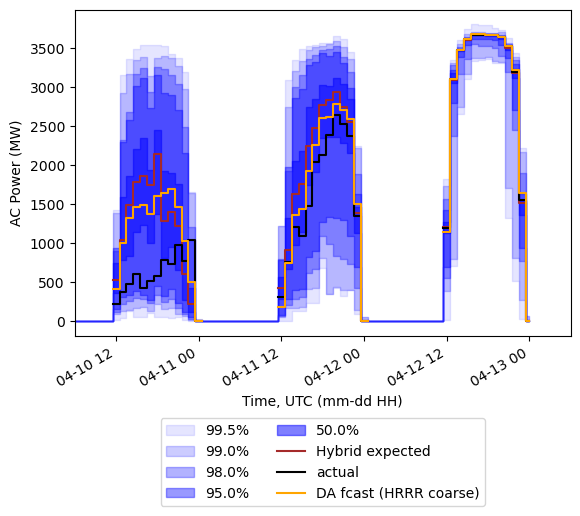

In [10]:
result_df = pd.read_pickle('data_files/hybrid_prob_fcast_results_20210408.pkl')

pi_list_xgb = [.9995, .999, .99, .96, .57] 
pi_list_rf = [.995, .99, .98, .95, .5]
# create percentile list:
pi_list = pi_list_rf
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index,# x
                     result_df[str(percentile_list[i])+'_p_ac'].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index,
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_act'],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_fcast'],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23),ncol=2)
plt.xlim([pd.Timestamp('2021-04-10 06:00'), pd.Timestamp('2021-04-13 06:00')])
plt.savefig('images/sample_output.png', dpi=400, bbox_inches='tight')
plt.show()

Images that are specifically for the presentation:

In [503]:
def sample_tcc_function_pres(member, date, plants_df):
    ds = Herbie(
        date=date,
        model='gefs',
        product="atmos.5",
        member=member,
        fxx=36).xarray('TCDC',remove_grib=True)
    
    region_extent = [-92, -80, 30, 35]
    min_lon = (region_extent[0]+360) % 360
    max_lon = (region_extent[1]+360) % 360
    min_lat = region_extent[2]
    max_lat = region_extent[3]

    # slice to region extent
    ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

    # select values for each plant, assign ac capacity
    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]
    lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
    lons = xr.DataArray(lon_gefs, dims='plant_number')
    df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()
    df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

    # weighted average tcc
    weighted_avg_tcc = df.filter(regex='tcc').multiply(df['ac_capacity'].values,axis='index').sum()/df['ac_capacity'].sum()
    weighted_avg_tcc = weighted_avg_tcc.values[0]

    ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 6]).STATES().BORDERS().ax
    p = ax.pcolormesh(
        ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
    )

    # add a colorbar
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
    )

    # add plant markers with size corresponding to ac capacity
    plt.scatter(
        plants_df.longitude,
        plants_df.latitude,
        s=plants_df.ac_capacity,
        edgecolors='black',
        color="red",
        alpha=0.6,
        transform=pc)

    ax.set_title(
        f"{ds.model.upper()} - Ensemble Member {member} \
        \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
        \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title('Weighted Avg. TCC = ' + f'{weighted_avg_tcc:06.2f}', loc="right")

    plt.savefig(
        'images/presentation_images/tcc_map_' + pd.Timestamp(date).strftime('%Y%m%dT%H') + '_' + member + '.png',
        dpi=400,
        bbox_inches='tight',
        )
    plt.show()
    return 

Make the figures:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


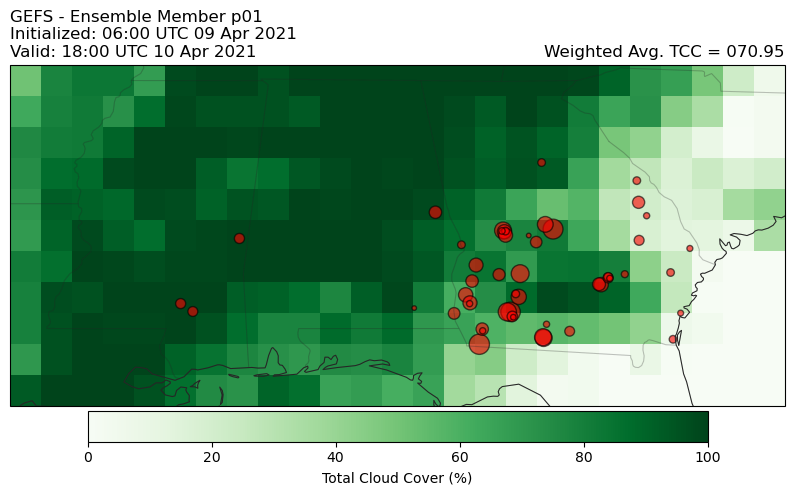

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


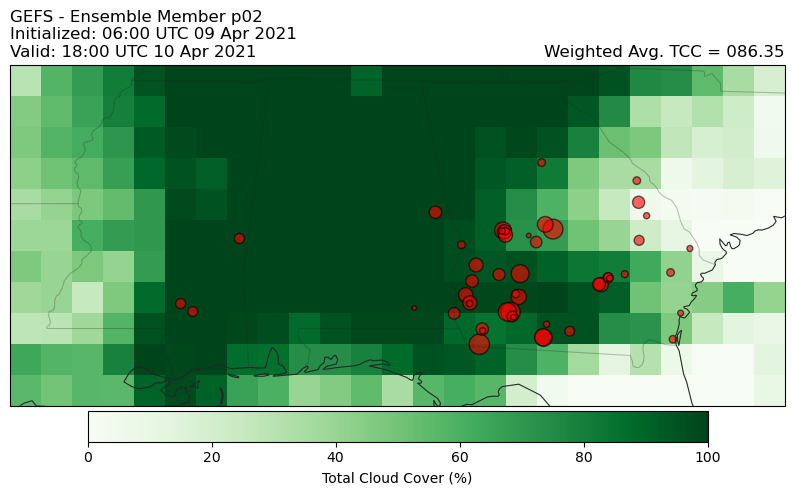

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


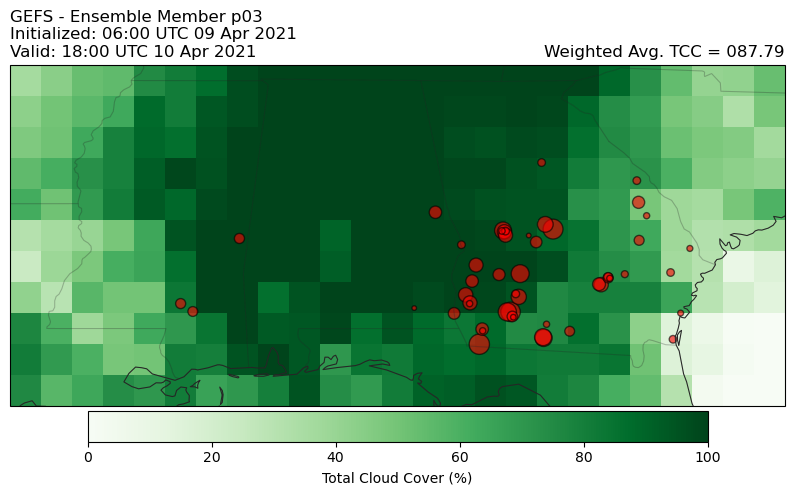

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


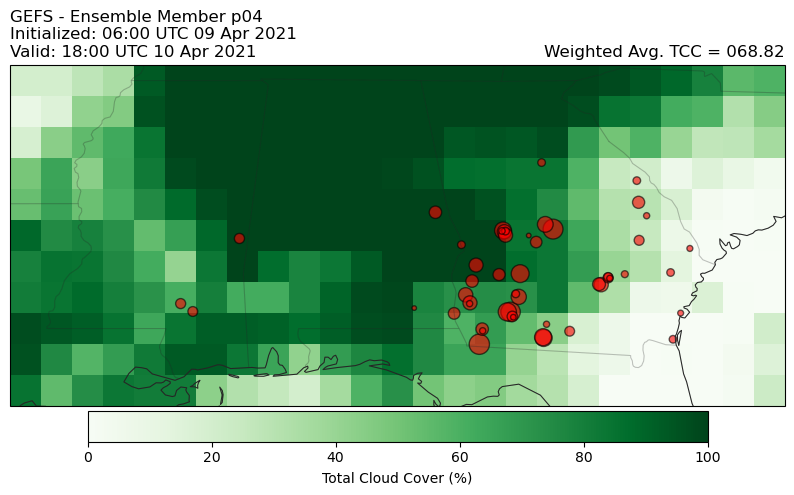

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


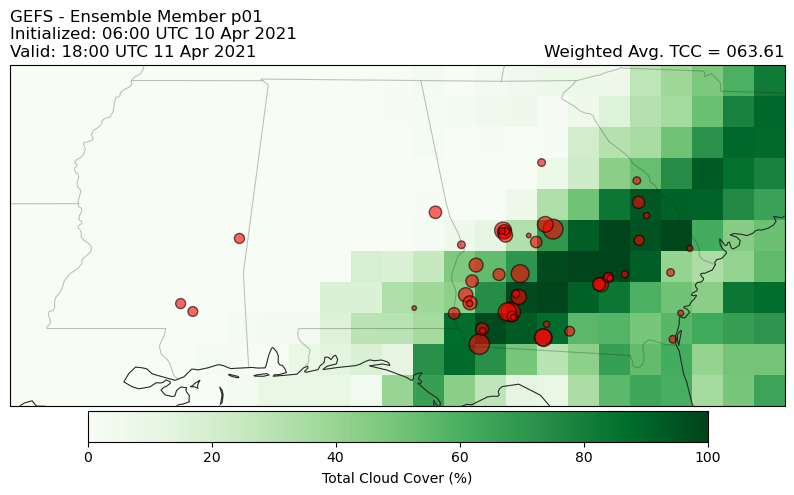

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


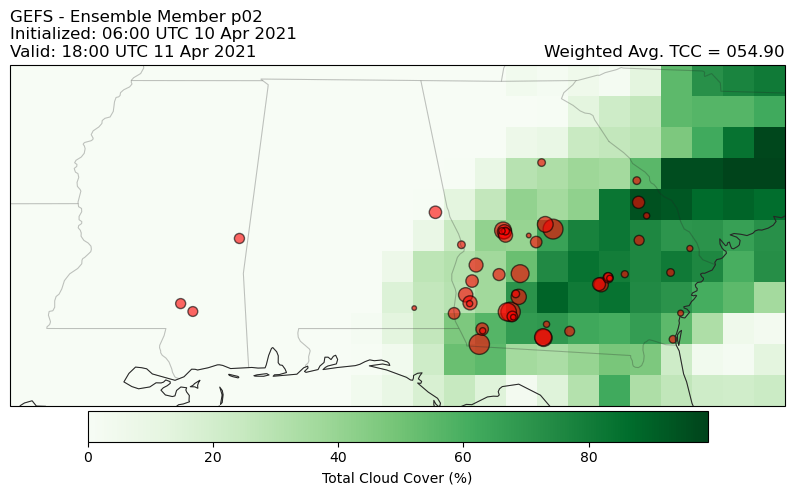

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


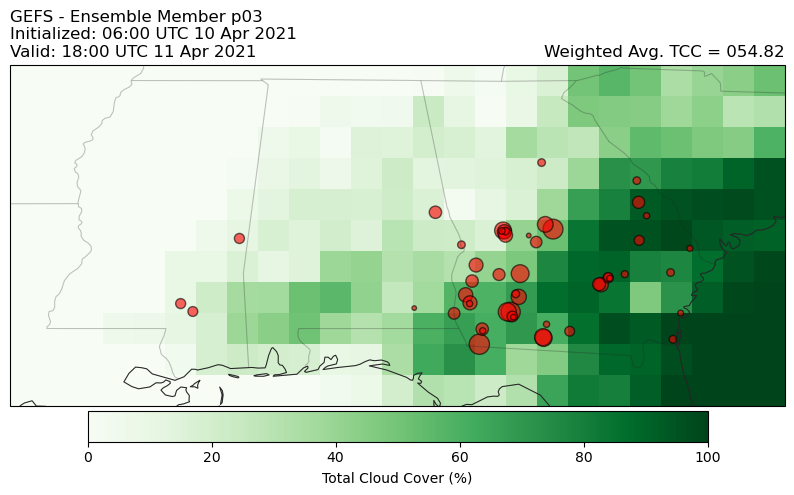

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


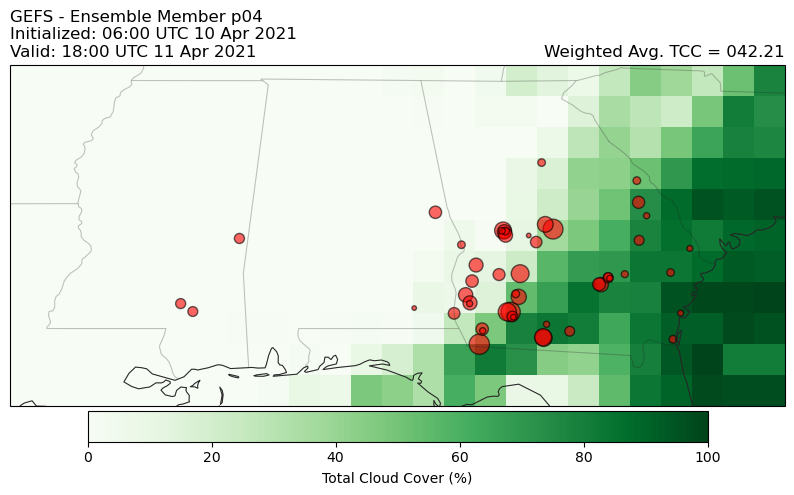

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


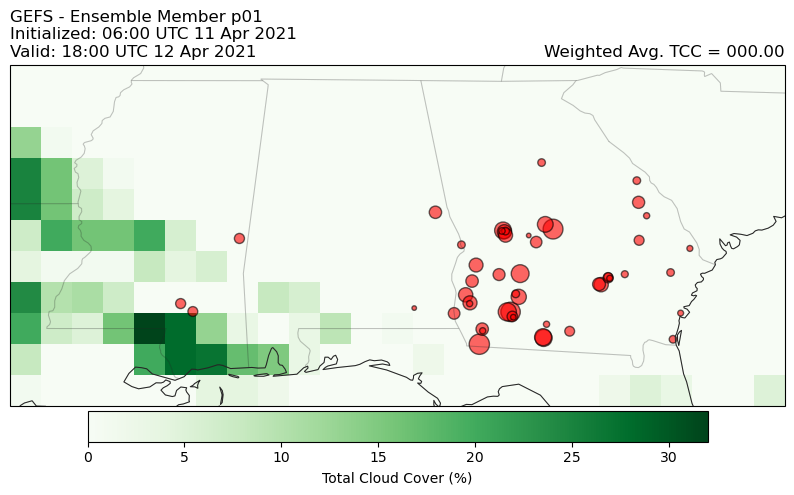

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


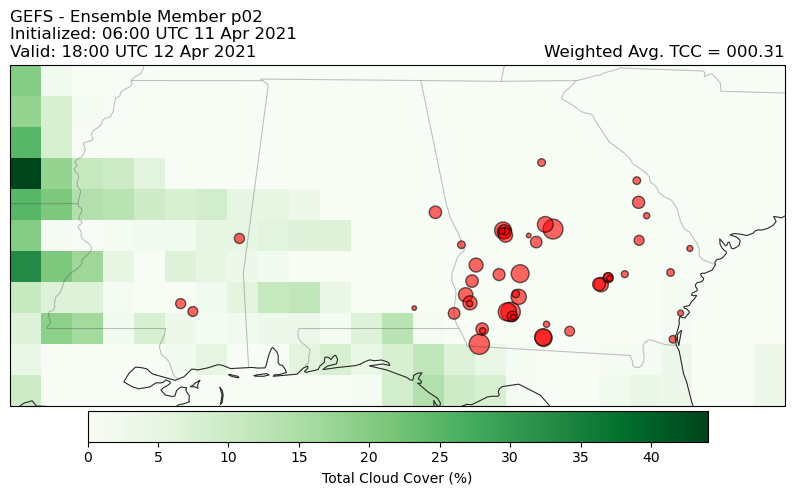

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


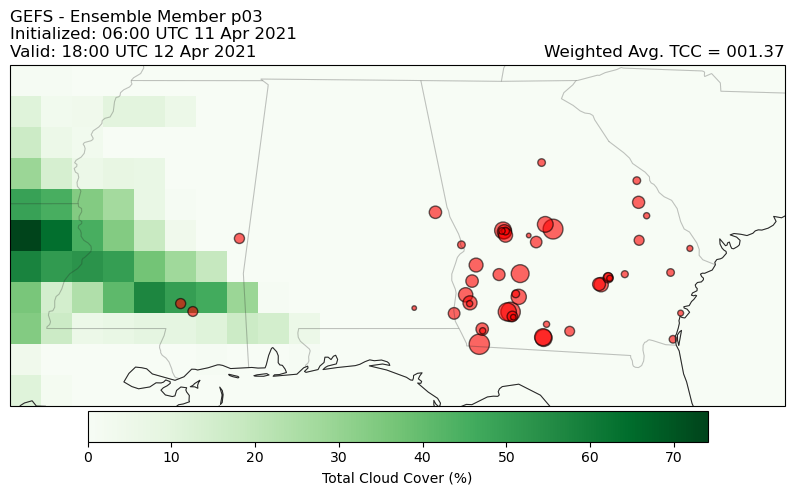

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


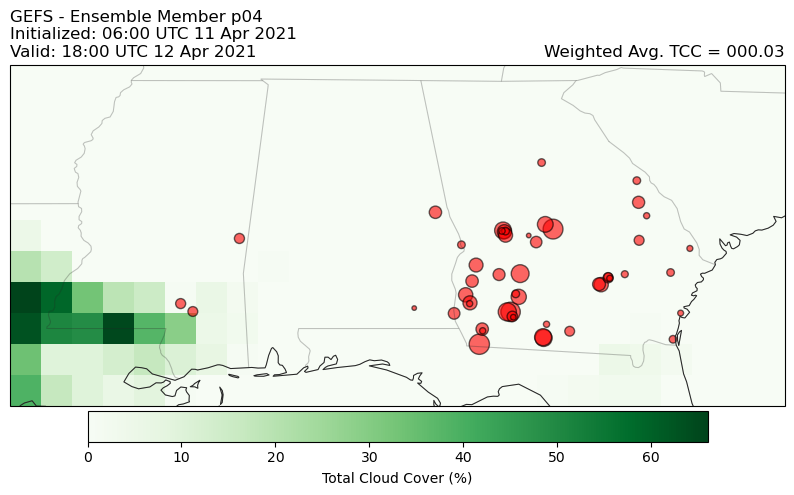

In [505]:
date = '2021-04-09 06:00'
sample_tcc_function_pres(member='p01',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p02',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p03',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p04',date=date, plants_df=plants_df)

date = '2021-04-10 06:00'
sample_tcc_function_pres(member='p01',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p02',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p03',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p04',date=date, plants_df=plants_df)

date = '2021-04-11 06:00'
sample_tcc_function_pres(member='p01',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p02',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p03',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p04',date=date, plants_df=plants_df)


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Dec-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\willh\data\gefs\20231209]


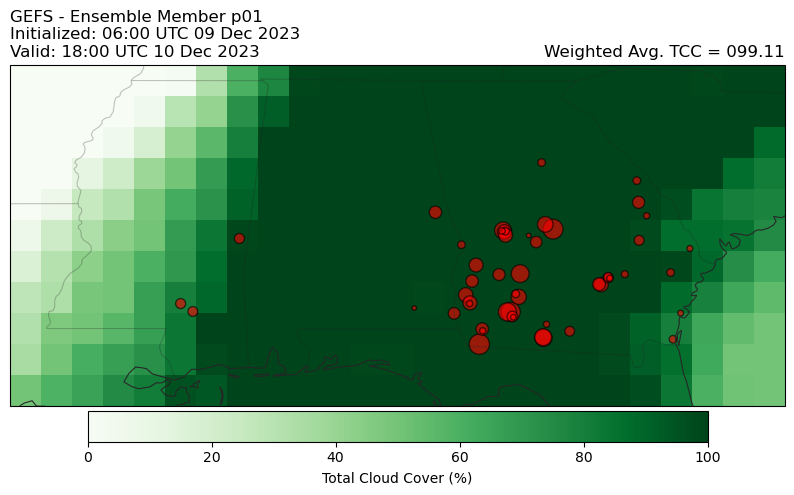

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Dec-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


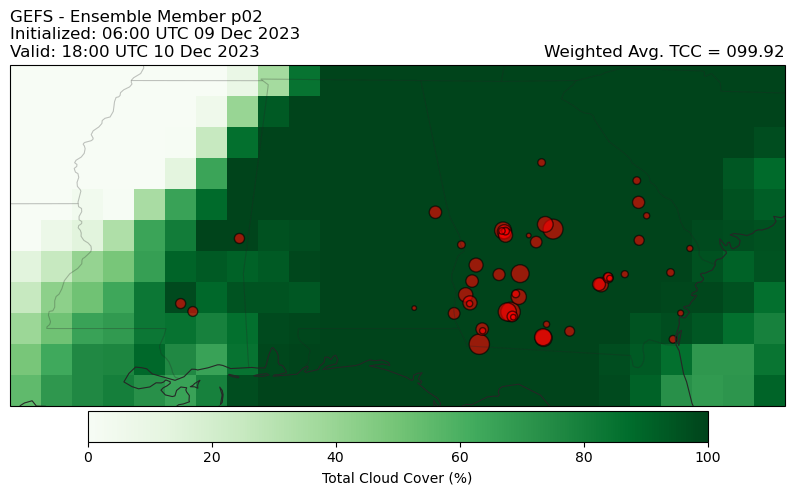

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Dec-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


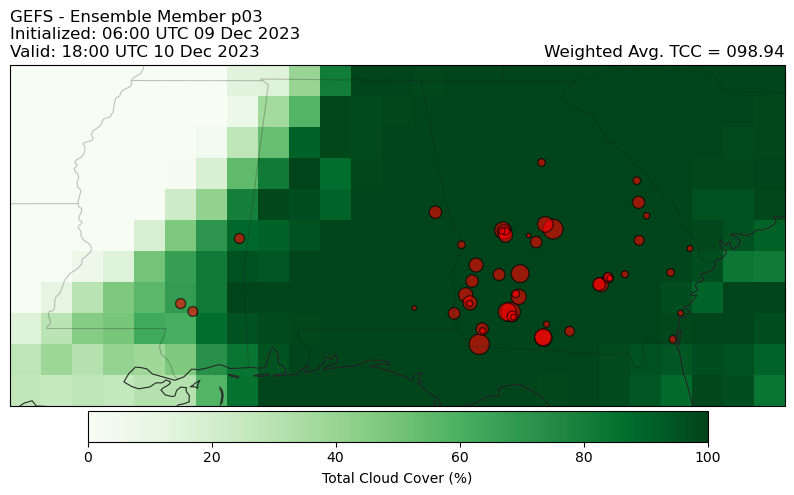

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Dec-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


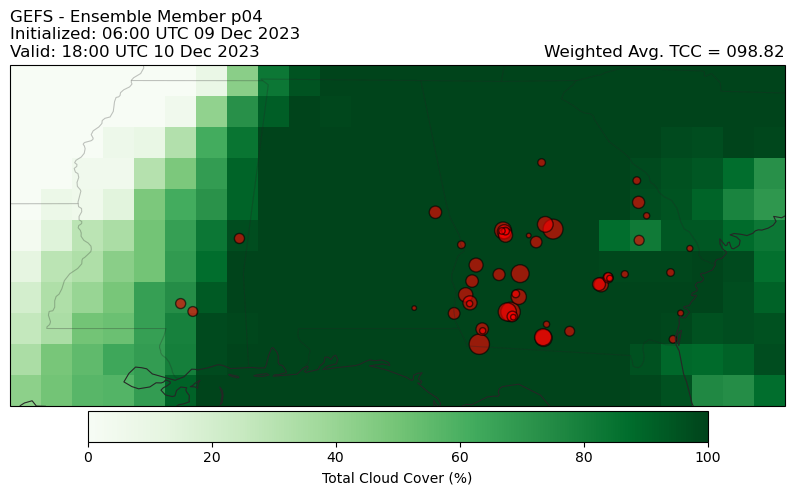

In [506]:

date = '2023-12-09 06:00'
sample_tcc_function_pres(member='p01',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p02',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p03',date=date, plants_df=plants_df)
sample_tcc_function_pres(member='p04',date=date, plants_df=plants_df)

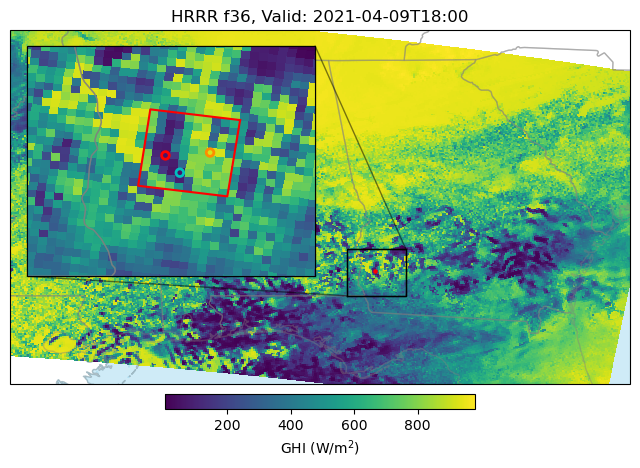

In [522]:
## Create first map
#------------------------
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_extent([-91, -80.5, 29.5, 35.5],
              crs=crs.PlateCarree()) ## Important
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax,
    transform=pc,
    cbar_kwargs={"shrink": 0.5,
                 "orientation": "horizontal",
                 "pad": 0.02,
                 'label':'GHI (W/$\mathregular{m^2}$)'},
)

# ax.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)
ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES, edgecolor='gray', alpha=0.4)
ax.set_title('HRRR f36, Valid: 2021-04-09T18:00')
# uncomment to add lat/lon labels
# ax.gridlines(draw_labels=True, linewidth=0)
#------------------------

plt.savefig("images/presentation_images/hrrr_map_01.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image

# Target point of interest
#------------------------
lat, lon = 31.42, -84.82

# Zoom range of interest around target point
lonmin, lonmax = -85.3, -84.3
latmin, latmax = 31, 31.8
ax.scatter(lon,lat,s=5,c='r',)
#------------------------

plt.savefig("images/presentation_images/hrrr_map_02.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image

# Inset map
#------------------------
coord = [[lonmin,latmin], [lonmin,latmax], [lonmax,latmax], [lonmax,latmin],[lonmin,latmin]]
xs, ys = zip(*coord) 
ax.plot(xs,ys,color='k', linewidth=1) 

x_pos = 0.26
y_pos = 0.63
size = 0.65                 
ax2 = ax.inset_axes(
                    [x_pos - size / 2, y_pos - size / 2, size, size],
                    projection=crs.PlateCarree(),
                    xlim=(lonmin, lonmax),
                    ylim=(latmin, latmax))
ax2.add_feature(cfeature.STATES, edgecolor='gray', alpha=0.7)
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax2,
    transform=pc,
    add_colorbar=False,
)
ax2.scatter(lon,lat,s=30,c='none', edgecolor='r',marker='o',linewidths=2)
ax.indicate_inset_zoom(ax2, edgecolor="black")
ax2.set_title('')
#------------------------

plt.savefig("images/presentation_images/hrrr_map_03.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image

## coarsen grid
#------------------------
ax2.plot(xs_coarse, ys_coarse,color='r') 
#------------------------

plt.savefig("images/presentation_images/hrrr_map_04.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image

## coarsened
#------------------------
ax2 = ax.inset_axes(
                    [x_pos - size / 2, y_pos - size / 2, size, size],
                    projection=crs.PlateCarree(),
                    xlim=(lonmin, lonmax),
                    ylim=(latmin, latmax))
ax2.add_feature(cfeature.STATES, edgecolor='gray', alpha=0.7)
ds_coarse.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax2,
    transform=pc,
    add_colorbar=False,
)
ax2.scatter(lon,lat,s=30,c='none', edgecolor='r',marker='o',linewidths=2)
# ax.indicate_inset_zoom(ax2, edgecolor="black")
ax2.plot(xs_coarse, ys_coarse,color='r') 
ax2.set_title('')
#------------------------

plt.savefig("images/presentation_images/hrrr_map_05.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image

#------------------------
ax2 = ax.inset_axes(
                    [x_pos - size / 2, y_pos - size / 2, size, size],
                    projection=crs.PlateCarree(),
                    xlim=(lonmin, lonmax),
                    ylim=(latmin, latmax))
ax2.add_feature(cfeature.STATES, edgecolor='gray', alpha=0.7)
ds_cropped.dswrf.plot(
    x="longitude",
    y="latitude",
    ax=ax2,
    transform=pc,
    add_colorbar=False,
)
ax2.scatter(lon,lat,s=30,c='none', edgecolor='r',marker='o',linewidths=2)
# ax.indicate_inset_zoom(ax2, edgecolor="black")
ax2.set_title('')
## manually highlight max and min points
# max
ax2.scatter(-84.665,31.43,s=30,c='none', edgecolor='darkorange',marker='o',linewidths=2)
# min
ax2.scatter(-84.77,31.36,s=30,c='none', edgecolor='c',marker='o',linewidths=2)

ax2.plot(xs_coarse, ys_coarse,color='r') 
#------------------------

plt.savefig("images/presentation_images/hrrr_map_06.png", dpi=400, bbox_inches='tight') # <-- uncomment this to save the image


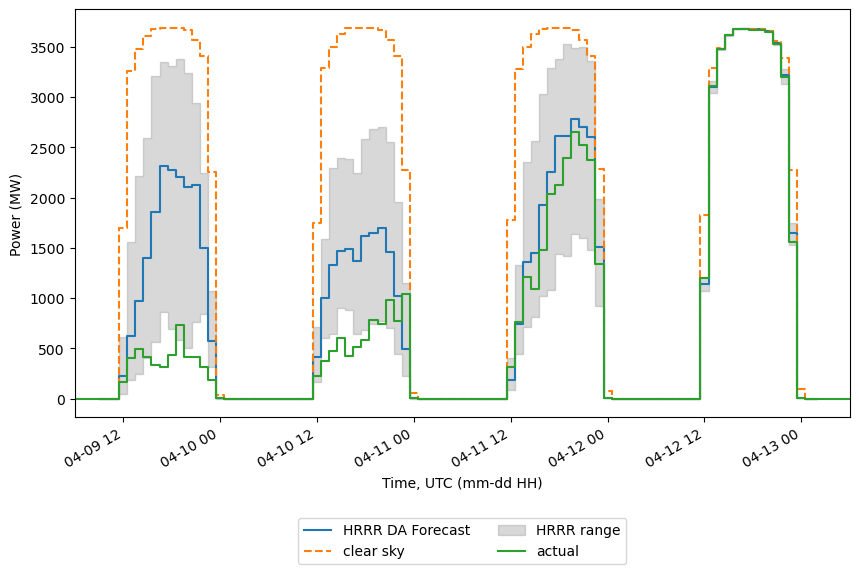

In [521]:
fig = plt.figure(figsize=[10,6])

# plot
mask = (power_ac_cs_all.index >= p_ac_hrrr_coarse_all.index[0]) & (power_ac_cs_all.index <= p_ac_hrrr_coarse_all.index[-1])
plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR DA Forecast')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky', linestyle='--')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='actual')
plt.ylabel('Power (MW)')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23),ncol=2)
plt.xlim([pd.Timestamp('2021-04-09 06:00'), pd.Timestamp('2021-04-13 06:00')])
plt.savefig('images/presentation_images/hrrr_max_min_cs_pres.png', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\willh\AppData\Local\Temp\ipykernel_28780\1451480931.py:37: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.gcf().autofmt_xdate()


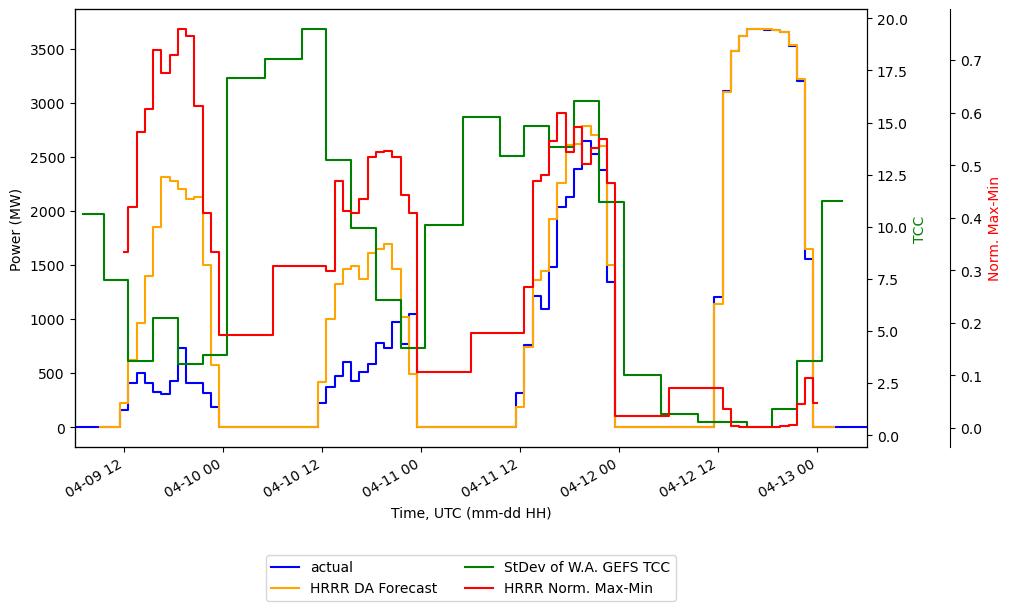

In [523]:
# Based on https://stackoverflow.com/a/45925049
# fig, ax1 = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches
fig, ax1 = plt.subplots(figsize=[10,6], layout='constrained')
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
ax1.set_xlabel('Time, UTC (mm-dd HH)')
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("TCC")
ax3.set_ylabel("Norm. Max-Min")

p1 = ax1.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='actual',
         color='blue',
         )

p2 = ax1.plot(p_ac_hrrr_coarse_all.index,
              p_ac_hrrr_coarse_all.power_ac,
              drawstyle='steps-mid',
              label='HRRR DA Forecast',
              color='orange',
              )

p3 = ax2.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label='StDev of W.A. GEFS TCC', color='green')

p4 = ax3.plot(max_min_norm.index, max_min_norm.max_min_norm, drawstyle='steps-mid',
         label='HRRR Norm. Max-Min', color='red')

# right, left, top, bottom
ax3.spines['right'].set_position(('outward', 60))

ax2.yaxis.label.set_color(p3[0].get_color())
ax3.yaxis.label.set_color(p4[0].get_color())
plt.gcf().autofmt_xdate()
plt.xlim([pd.Timestamp('2021-04-09 06:00'), pd.Timestamp('2021-04-13 06:00')])
plt.legend(handles=p1+p2+p3+p4, loc='upper center', bbox_to_anchor=(0.5, -0.23),ncol=2)
plt.savefig('images/presentation_images/indicators_timeseries_pres.png', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\willh\AppData\Local\Temp\ipykernel_28780\1490835270.py:28: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.gcf().autofmt_xdate()


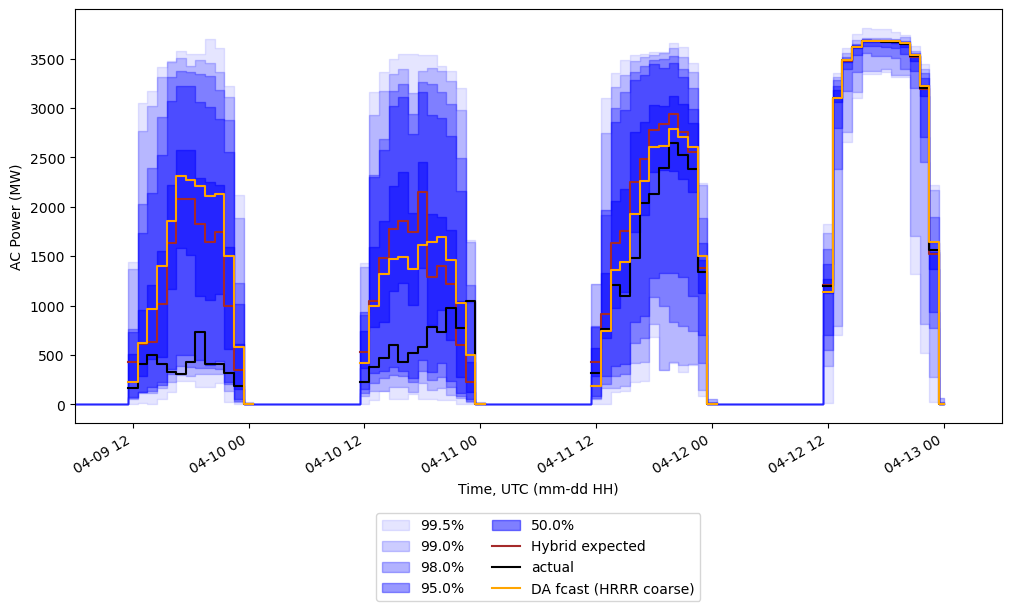

In [526]:
result_df = pd.read_pickle('data_files/hybrid_prob_fcast_results_20210408.pkl')
fig, ax1 = plt.subplots(figsize=[10,6], layout='constrained')
pi_list_xgb = [.9995, .999, .99, .96, .57] 
pi_list_rf = [.995, .99, .98, .95, .5]
# create percentile list:
pi_list = pi_list_rf
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index,# x
                     result_df[str(percentile_list[i])+'_p_ac'].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index,
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_act'],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_fcast'],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2)
plt.xlim([pd.Timestamp('2021-04-09 06:00'), pd.Timestamp('2021-04-13 06:00')])
plt.savefig('images/presentation_images/sample_output_pres.png', dpi=400, bbox_inches='tight')
plt.show()

In [528]:
plants_df.ac_capacity.sum()

3716.3